In [ ]:
import pandas as pd
import re
import string
import torch
import transformers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

In [ ]:
import pandas as pd
label = pd.read_csv("fnc-1/train_stances.csv")
body = pd.read_csv("fnc-1/train_bodies.csv")

In [ ]:
data = pd.merge(label, body, on='Body ID', how='inner')
data.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Créer une instance de LabelEncoder
label_encoder = LabelEncoder()

# Appliquer le label encoding sur la colonne 'labels'
data['Stance'] = label_encoder.fit_transform(data['Stance'])

<h3>Data Preprocessing</h3>

In [ ]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Définition de la fonction de nettoyage du texte
def clean_text(text):
    # Supprimer les caractères spéciaux, les chiffres, etc.
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Définition de la fonction de tokenization
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Définition de la fonction de suppression des stop words
def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

# Définition de la fonction de lemmatisation
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens


In [ ]:
import pandas as pd


# Suppression des valeurs manquantes
data = data.dropna()

# Nettoyage du texte
data['Headline'] = data['Headline'].apply(lambda x: clean_text(x))

# Tokenization
data['Headline'] = data['Headline'].apply(lambda x: tokenize_text(x))

# Suppression des stop words
data['Headline'] = data['Headline'].apply(lambda x: remove_stop_words(x))

# Lemmatisation/Stemming
data['Headline'] = data['Headline'].apply(lambda x: lemmatize_text(x))

In [ ]:
# Nettoyage du texte
data['articleBody'] = data['articleBody'].apply(lambda x: clean_text(x))

# Tokenization
data['articleBody'] = data['articleBody'].apply(lambda x: tokenize_text(x))

# Suppression des stop words
data['articleBody'] = data['articleBody'].apply(lambda x: remove_stop_words(x))

# Lemmatisation/Stemming
data['articleBody'] = data['articleBody'].apply(lambda x: lemmatize_text(x))

In [ ]:
data['Headline'] = data['Headline'].apply(lambda liste: ' '.join(map(str, liste)))

In [ ]:
data['articleBody'] = data['articleBody'].apply(lambda liste: ' '.join(map(str, liste)))

<h3>Oversample the smallest class<h3>

In [ ]:
from sklearn.model_selection import train_test_split


# Séparation en features (X) et labels (y)
X = data[['articleBody', 'Headline']]
y = data['Stance']

# Utilisation de train_test_split pour diviser le dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from collections import Counter
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

In [ ]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

In [ ]:
X_res.shape

In [ ]:
y_res

In [ ]:
train_df = pd.DataFrame({'articleBody': X_res['articleBody'], 'Headline': X_res['Headline'], 'Stance': y_res})
test_df = pd.DataFrame({'articleBody': X_test['articleBody'], 'Headline': X_test['Headline'], 'Stance': y_test})

In [ ]:
train_df['articleBody']

In [ ]:
train_df['Headline']

<h2><strong> Deep Learning (LSTM Siamois) </strong></h2>

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate
from imblearn.over_sampling import RandomOverSampler

# Supposons que vous ayez déjà défini train_df et test_df
# ...

# Créer un vecteurisateur Bag of Words
vectorizer = CountVectorizer(max_features=100)

# Transformer les textes en vecteurs
X_train_text = vectorizer.fit_transform(train_df['articleBody'])
X_test_text = vectorizer.transform(test_df['articleBody'])
X_train_headline = vectorizer.fit_transform(train_df['Headline'])
X_test_headline = vectorizer.transform(test_df['Headline'])


y_train_encoded = train_df['Stance']
y_test_encoded = test_df['Stance']

# Convertir les matrices CSR en matrices NumPy
X_train_text_np = X_train_text.toarray()
X_test_text_np = X_test_text.toarray()
X_train_headline_np = X_train_headline.toarray()
X_test_headline_np = X_test_headline.toarray()


# Créer le modèle
embedding_dim = 50
max_length = 100

input_text = Input(shape=(X_train_text_np.shape[1],))
embedding_text = Embedding(input_dim=500, output_dim=embedding_dim, input_length=X_train_text_np.shape[1])(input_text)
lstm_text = LSTM(100)(embedding_text)

input_headline = Input(shape=(X_train_headline_np.shape[1],))
embedding_headline = Embedding(input_dim=500, output_dim=embedding_dim, input_length=X_train_headline_np.shape[1])(input_headline)
lstm_headline = LSTM(100)(embedding_headline)

concatenated = concatenate([lstm_text, lstm_headline])
output = Dense(units=4, activation='softmax')(concatenated)

model = Model(inputs=[input_text, input_headline], outputs=output)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle avec les données converties en matrices NumPy
model.fit([X_train_text_np, X_train_headline_np], y_train_encoded, epochs=5, batch_size=64, validation_split=0.2)

# Évaluer le modèle
loss, accuracy = model.evaluate([X_test_text_np, X_test_headline_np], y_test_encoded)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Le data preprocessing et un dataset bien équilibré a permis d'augmenter grandement la performance. Je suis passé de 30 % de précision à 60%.

<h2><strong> Partie III: LLM (dataset: pairwise sequence classification) </strong></h2>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


label = pd.read_csv("fnc-1/train_stances.csv")
body = pd.read_csv("fnc-1/train_bodies.csv")


data = pd.merge(label, body, on='Body ID', how='inner')
data.head()



# Séparation en features (X) et labels (y)
X = data[['articleBody', 'Headline']]
y = data['Stance']

# Utilisation de train_test_split pour diviser le dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
somme = 0
accuracy = 0
for i in range (100):
    articleBody = X_test.loc[i, "articleBody"]
    Headline = X_test.loc[i, "Headline"]
    scores = model.predict([(articleBody, Headline)])

    #Convert scores to labels
    label_mapping = ['unrelated', 'discuss', 'agree', 'disagree']
    labels = [label_mapping[score_max] for score_max in scores.argmax(axis=1)]
    
    truth = "['" + y_test[i] + "']"
    print(truth)
    print(labels)
    
    somme +=1
    if truth == str(labels):
        accuracy += 1
       

In [ ]:
print("la precision du modèle est :", accuracy/somme)

La performance du modèle est très mauvaises. Parce que le modèle a été entrainé sur les labels : "contradiction", "entailment" et "neutral". Afin de résoudre ce problème nous avons fine tune le modèle

<h2><strong> Fine - Tunning </strong></h2>

In [105]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split


label = pd.read_csv("fnc-1/train_stances.csv")
body = pd.read_csv("fnc-1/train_bodies.csv")


data = pd.merge(label, body, on='Body ID', how='inner')
data.head()

# Créer une instance de LabelEncoder
label_encoder = LabelEncoder()

# Appliquer le label encoding sur la colonne 'labels'
data['Stance'] = label_encoder.fit_transform(data['Stance'])


# Séparation en features (X) et labels (y)
X = data[['articleBody', 'Headline']]
y = data['Stance']

# Utilisation de train_test_split pour diviser le dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
data = pd.DataFrame({'articleBody': X_res['articleBody'], 'Headline': X_res['Headline'], 'Stance': y_res})

In [106]:
data.shape

(117220, 3)

In [107]:
#data = data.sample(frac=0.1, random_state=42)
data.shape

(117220, 3)

In [108]:
import pandas as pd

index_plus_long = data['articleBody'].apply(len).idxmax()

# Extraire l'article le plus long
plus_long_article = data.loc[index_plus_long, 'articleBody']

# Afficher la longueur et le contenu de l'article le plus long
print(f"Longueur de l'article le plus long : {len(plus_long_article)}")



Longueur de l'article le plus long : 27579


In [109]:
import pandas as pd

index_plus_long = data['Headline'].apply(len).idxmax()

# Extraire l'article le plus long
plus_long_article = data.loc[index_plus_long, 'Headline']

# Afficher la longueur et le contenu de l'article le plus long
print(f"Longueur du titre le plus long : {len(plus_long_article)}")

Longueur du titre le plus long : 225


Je tronque les articles parce qu'il depasse la limite des 500 tokens

In [110]:
data['articleBody'] = data['articleBody'].apply(lambda x: ' '.join(x.split()[:300]))

In [111]:
#data = data.sample(frac=0.01, random_state=42)

In [112]:
data.shape

(117220, 3)

In [113]:
import pandas as pd
from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


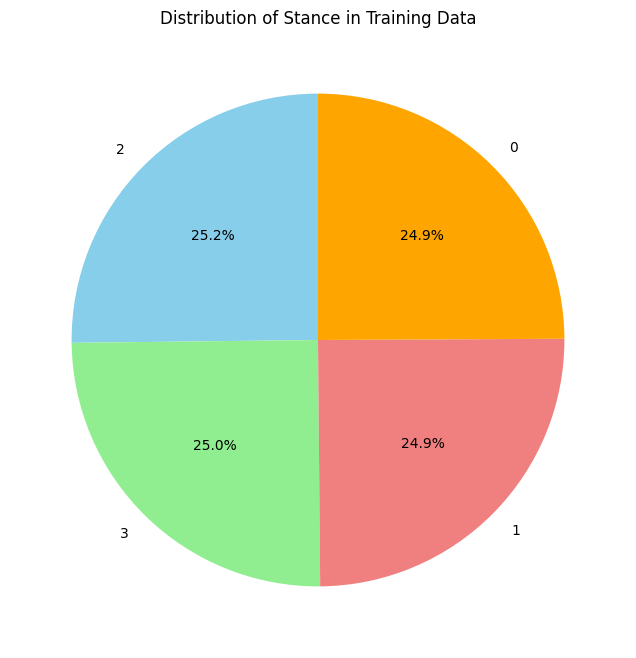

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_data is your DataFrame containing the training data

# Get the distribution of values in the "Stance" column
stance_distribution = train_data['Stance'].value_counts()

# Plot the distribution as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(stance_distribution, labels=stance_distribution.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'lightcoral', 'orange'])
plt.title('Distribution of Stance in Training Data')
plt.show()


In [115]:
from sentence_transformers import CrossEncoder, InputExample, util
from torch.utils.data import DataLoader
train_examples = [InputExample(texts=[row['Headline'], row['articleBody']], label=row['Stance']) for _, row in train_data.iterrows()]
# Fine-tuner le modèle
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=8)

In [116]:
test_examples = [InputExample(texts=[row['Headline'], row['articleBody']], label=row['Stance']) for _, row in test_data.iterrows()]
# Fine-tuner le modèle
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=8)

In [119]:
import pandas as pd
from torch.utils.data import DataLoader
from sentence_transformers import CrossEncoder, InputExample, util

# Charger le modèle de base
model = CrossEncoder('cross-encoder/nli-roberta-base', num_labels = 4)

RuntimeError: Error(s) in loading state_dict for RobertaForSequenceClassification:
	size mismatch for classifier.out_proj.weight: copying a param with shape torch.Size([3, 768]) from checkpoint, the shape in current model is torch.Size([4, 768]).
	size mismatch for classifier.out_proj.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([4]).
	You may consider adding `ignore_mismatched_sizes=True` in the model `from_pretrained` method.

In [ ]:
model.fit(train_dataloader)

# Sauvegarder le modèle fine-tuné si nécessaire
model.save('fine_tuned_model')


Epoch: 100%|██████████| 1/1 [22:53<00:00, 1373.74s/it]


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


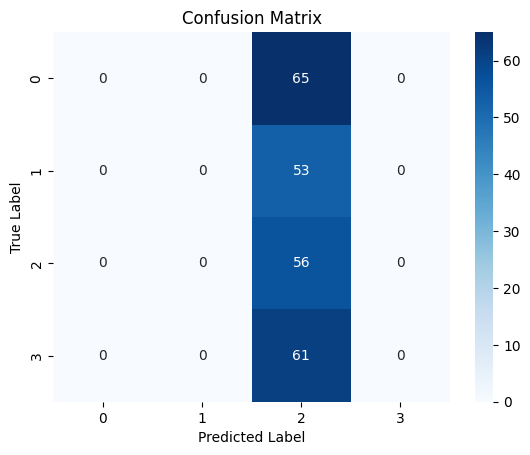

Accuracy: 23.83%


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

# Assuming test_df is your DataFrame containing the test data

# Replace 'RobertaForSequenceClassification' with the actual model class you used for fine-tuning
fine_tuned_model = RobertaForSequenceClassification.from_pretrained('fine_tuned_model')
tokenizer = RobertaTokenizer.from_pretrained('fine_tuned_model')

# Initialize an empty list to store predictions
all_predictions = []

# Iterate through all rows in the test data
for index, row in test_data.iterrows():
    # Get the articleBody and Headline for each test case
    test_case = [row["articleBody"], row["Headline"]]
    
    # Tokenize the input
    input_ids = tokenizer.encode(test_case[0], test_case[1], return_tensors='pt')
    
    # Make a prediction using the fine-tuned model
    with torch.no_grad():
        prediction = fine_tuned_model(input_ids)
    
    # Get the predicted class
    predicted_class = np.argmax(prediction.logits.numpy())
    
    # Append the predicted class to the list
    all_predictions.append(predicted_class)

# Get the true classes from the test data
true_classes = test_data["Stance"].astype(int)

# Generate the confusion matrix
confusion_mat = confusion_matrix(true_classes, all_predictions)

# Calculate accuracy
accuracy = accuracy_score(true_classes, all_predictions)

# Plot the confusion matrix as a heatmap
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')


Le modèle n'apprends pas.